# U-Net and Experiments

This file contains the U-Net model, as well as a number of experiments performed on the model to maximise performance.

# Mount

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Imports

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as random

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping


from skimage.transform import resize
from skimage.color import rgb2gray

from google.colab import files

# Helper functions

## View sample

In [3]:
def display_sample_image_mask(images, masks, index):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    
    axes[0].imshow(images[index])
    axes[0].set_title("Image")
    axes[0].axis('off')
    
    axes[1].imshow(masks[index].squeeze(), cmap="gray")
    axes[1].set_title("Mask")
    axes[1].axis('off')

    plt.tight_layout(pad=1)
    plt.show()

## Evaluation metrics

In [4]:
def evaluation_metrics(model):
  history = pd.DataFrame(model.history)
  history = history.rename(columns = {'loss': 'Loss', 'iou': 'IoU', 'val_loss': 'Validation Loss', 'val_iou': 'Validation IoU'})
  hist_iou = history['IoU']
  hist_val_iou = history['Validation IoU']
  hist_loss = history['Loss']
  hist_val_loss = history['Validation Loss']

  plt.figure(figsize=(7, 7), dpi=80)

  # Plot IoU and validation IoU
  plt.subplot(211)
  plt.plot(hist_iou, color='tab:blue', marker='o', linewidth=3)
  plt.plot(hist_val_iou, color='tab:green', marker='o', linewidth=3)
  plt.ylabel('IoU', fontsize=14)
  plt.xlabel('Epoch', fontsize=14)
  plt.legend(['Training IoU', 'Validation IoU'], loc='upper right')
  plt.xticks(np.arange(len(range(0, 7))), np.arange(1, len(range(0, 8))))
  plt.yticks(np.arange(0, 0.11, 0.01))
  plt.grid()

  # Plot training loss and validation loss
  plt.subplot(212)
  plt.plot(hist_loss, color='#153BBF', marker='o', linewidth=3)
  plt.plot(hist_val_loss, color='#158440', marker='o', linewidth=3)
  plt.ylabel('Loss', fontsize=14)
  plt.xlabel('Epoch', fontsize=14)
  plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
  plt.xticks(np.arange(len(range(0, 7))), np.arange(1, len(range(0, 8))))
  plt.yticks(np.arange(0, 0.35, 0.05))
  plt.grid()

  plt.tight_layout(pad=3.5)
  plt.show()




## Visualise prediction

In [5]:
def visualise_prediction(new_image_path, true_mask_path, model, threshold):
    # Load in the new image.
    new_image = plt.imread(new_image_path)

    # Remove the alpha channel.
    if new_image.shape[2] == 4:
        new_image = new_image[..., :3]

    # Resize image, and add the batch dimension to make it compatible with CNN.
    new_image_resized = resize(new_image, (512, 512))
    new_image_batch = np.expand_dims(new_image_resized, axis=0)

    # Make a prediction.
    prediction = model.predict(new_image_batch)

    # Create a binary mask. Each pixel value will be 1 or 0 dependent on the confidence threshold.
    predicted_mask = (prediction > threshold).astype(np.uint8)[0, ..., 0]

    # Convert the new image into 0-255 int values so it can be visualised.
    original_image = (new_image_resized * 255).astype(np.uint8)

    # Load in the true mask.
    true_mask = plt.imread(true_mask_path)

    # Remove the alpha channel.
    if true_mask.shape[2] == 4:
        true_mask = true_mask[..., :3]

    # Convert to greyscale and normalise.
    true_mask_gray = rgb2gray(true_mask)
    true_mask_normalised = (true_mask_gray.astype(np.float32) / 255.0)

    # Create plot.
    fig, axes = plt.subplots(1, 3, figsize=(9, 6))

    # Original image.
    axes[0].imshow(original_image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    # True mask.
    axes[1].imshow(true_mask_normalised, cmap='gray')
    axes[1].set_title("True Mask")
    axes[1].axis('off')

    # Predicted mask.
    axes[2].imshow(predicted_mask, cmap='gray', vmin=0, vmax=1)
    axes[2].set_title(f"Predicted Mask (>{int(threshold * 100)}%)")
    axes[2].axis('off')

    plt.tight_layout(pad=1)
    plt.show()

# U-Net CNN Model

## Data Pre-Processing

### Load in images and masks

In [ ]:
images_folder = "/content/drive/My Drive/Individual Project/images"
masks_folder = "/content/drive/My Drive/Individual Project/masks"

In [ ]:
image_paths = sorted([os.path.join(images_folder, file) for file in os.listdir(images_folder)])
mask_paths = sorted([os.path.join(masks_folder, file) for file in os.listdir(masks_folder)])

### Pre-process images

In [ ]:
images = np.array([img_to_array(load_img(path, target_size=(512, 512))) for path in image_paths])
masks = np.array([img_to_array(load_img(path, target_size=(512, 512), color_mode="grayscale")) for path in mask_paths])

### Normalise images

In [ ]:
images = images.astype(np.float32) / 255.0
masks = masks.astype(np.float32) / 255.0

### View Sample

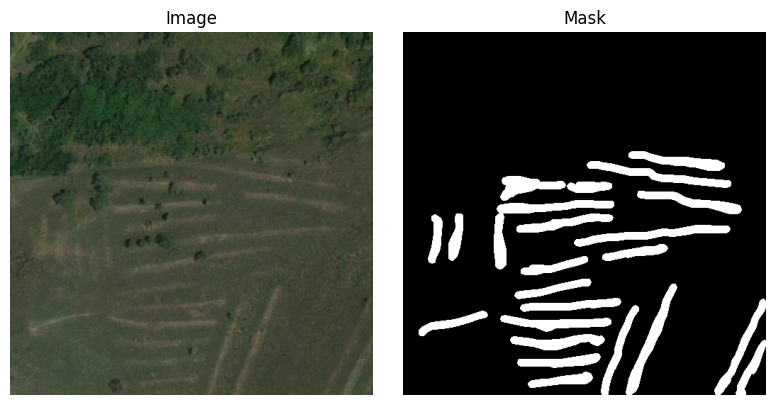

In [ ]:
sample_index = random.randint(0, len(images))
display_sample_image_mask(images, masks, sample_index)

### Splitting the data into train and validation

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

## U-Net Model - Base Model

In [ ]:
def unet(input_size=(512, 512, 3)):
    inputs = Input(input_size)

    # Encoding path (contraction).
    # Block 1 - Two convolution layers and a max pooling layer.
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    # Block 2 - Two convolution layers and a max pooling layer.
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Block 3 - Two convolution layers and a max pooling layer.
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Block 4 - Two convolution layers and a max pooling layer.
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottleneck.
    # Block 5 - Two convolution layers.
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # Decoding path (expansion).
    # Block 6 - Transpose layer, concatinating conv4, and two convolution layers.
    upsamp6 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5)
    merge6 = concatenate([conv4, upsamp6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    # Block 7 - Transpose layer, concatinating conv3, and two convolution layers.
    upsamp7 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    merge7 = concatenate([conv3, upsamp7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    # Block 8 - Transpose layer, concatinating conv2, and two convolution layers.
    upsamp8 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    merge8 = concatenate([conv2, upsamp8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    # Block 9 - Transpose layer, concatinating conv1, and two convolution layers.
    upsamp9 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    merge9 = concatenate([conv1, upsamp9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    # Output layer - Applying sigmoid activation.
    output = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=output)

    return model


### Instantiate and Compile U-Net model

In [ ]:
unet_model = unet(input_size=(512, 512, 3))

def iou(y_true, y_pred):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    intersection = K.sum(y_true_flatten * y_pred_flatten)
    return (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)

def iou_loss(y_true, y_pred):
    return -iou(y_true, y_pred)

optimizer = tf.keras.optimizers.Adam()
unet_model.compile(optimizer=optimizer, loss=[iou_loss], metrics=[iou])

#unet_model.summary()

### Training the U-Net model

In [ ]:
batch_size = 8
epochs = 10

model_history = unet_model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val, y_val))

unet_model.save("base_model.hdf5")

Epoch 1/10
10/10 [==============================] - 24s 2s/step - loss: -0.0903 - iou: 0.0903 - val_loss: -0.0862 - val_iou: 0.0836
Epoch 2/10
10/10 [==============================] - 17s 2s/step - loss: -0.0965 - iou: 0.0965 - val_loss: -0.0920 - val_iou: 0.0883
Epoch 3/10
10/10 [==============================] - 17s 2s/step - loss: -0.1109 - iou: 0.1109 - val_loss: -0.1110 - val_iou: 0.1077
Epoch 4/10
10/10 [==============================] - 17s 2s/step - loss: -0.1237 - iou: 0.1237 - val_loss: -0.1261 - val_iou: 0.1171
Epoch 5/10
10/10 [==============================] - 18s 2s/step - loss: -0.1276 - iou: 0.1276 - val_loss: -0.0855 - val_iou: 0.0829
Epoch 6/10
10/10 [==============================] - 16s 2s/step - loss: -0.0924 - iou: 0.0924 - val_loss: -0.0846 - val_iou: 0.0820
Epoch 7/10
10/10 [==============================] - 16s 2s/step - loss: -0.0913 - iou: 0.0913 - val_loss: -0.0845 - val_iou: 0.0820
Epoch 8/10
10/10 [==============================] - 16s 2s/step - loss: -0.0

### Evaluation Metrics

In [ ]:
history = pd.DataFrame(model_history.history)

history = history.rename(columns = {'loss': 'IoU Loss', 'iou': 'IoU', 'val_loss': 'Validation IoU Loss', 'val_iou': 'Validation IoU'})
hist_iou = history['IoU']
hist_val_iou = history['Validation IoU']
hist_loss = history['IoU Loss']
hist_val_loss = history['Validation IoU Loss']

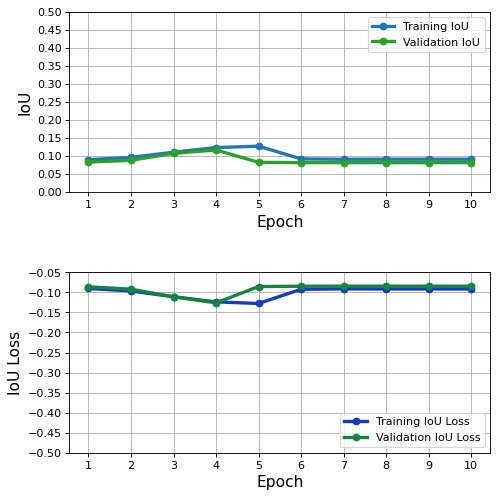

In [ ]:
plt.figure(figsize=(7, 7), dpi=80)

# Plot IoU and validation IoU.
plt.subplot(211)
plt.plot(hist_iou, color='tab:blue', marker='o', linewidth=3)
plt.plot(hist_val_iou, color='tab:green', marker='o', linewidth=3)
plt.ylabel('IoU', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.legend(['Training IoU', 'Validation IoU'], loc='upper right')
plt.xticks(np.arange(len(range(0, 10))), np.arange(1, len(range(0, 11))))
plt.yticks(np.arange(0, 0.55, 0.05))
plt.grid()

# Plot training IoU loss and validation IoU loss.
plt.subplot(212)
plt.plot(hist_loss, color='#153BBF', marker='o', linewidth=3)
plt.plot(hist_val_loss, color='#158440', marker='o', linewidth=3)
plt.ylabel('IoU Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.legend(['Training IoU Loss', 'Validation IoU Loss'], loc='lower right')
plt.xticks(np.arange(len(range(0, 10))), np.arange(1, len(range(0, 11))))
plt.yticks(np.arange(-0.5, 0, 0.05))
plt.grid()

plt.tight_layout(pad=3.5)
plt.savefig("base_model.png")
plt.show()

## U-Net Model - Loss and Optimiser

### Instantiate and Compile U-Net model

In [ ]:
unet_model2 = unet(input_size=(512, 512, 3))

optimiser = tf.keras.optimizers.Adam()
unet_model2.compile(optimizer=optimiser, loss='binary_focal_crossentropy', metrics=[iou])

#unet_model.summary()

### Training the U-Net model

In [ ]:
batch_size = 8
epochs = 10

model_history2 = unet_model2.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val, y_val))

unet_model2.save("base_model_optimisation.hdf5")

Epoch 1/10
10/10 [==============================] - 24s 2s/step - loss: 0.0755 - iou: 0.0600 - val_loss: 0.0435 - val_iou: 0.0506
Epoch 2/10
10/10 [==============================] - 17s 2s/step - loss: 0.0451 - iou: 0.0558 - val_loss: 0.0421 - val_iou: 0.0535
Epoch 3/10
10/10 [==============================] - 17s 2s/step - loss: 0.0438 - iou: 0.0600 - val_loss: 0.0414 - val_iou: 0.0588
Epoch 4/10
10/10 [==============================] - 17s 2s/step - loss: 0.0428 - iou: 0.0648 - val_loss: 0.0399 - val_iou: 0.0607
Epoch 5/10
10/10 [==============================] - 17s 2s/step - loss: 0.0426 - iou: 0.0702 - val_loss: 0.0402 - val_iou: 0.0593
Epoch 6/10
10/10 [==============================] - 17s 2s/step - loss: 0.0425 - iou: 0.0700 - val_loss: 0.0406 - val_iou: 0.0565
Epoch 7/10
10/10 [==============================] - 17s 2s/step - loss: 0.0423 - iou: 0.0692 - val_loss: 0.0398 - val_iou: 0.0604
Epoch 8/10
10/10 [==============================] - 17s 2s/step - loss: 0.0423 - iou: 0.06

### Evaluation Metrics

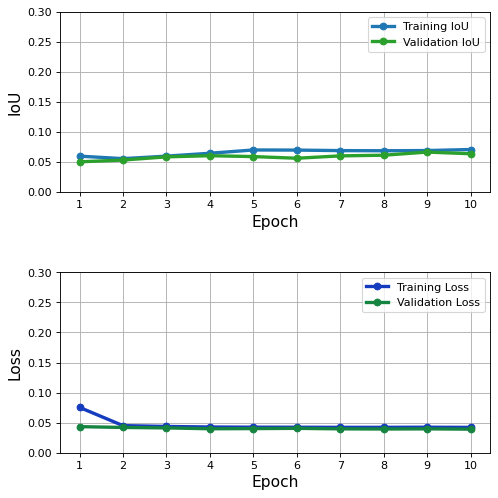

In [ ]:
evaluation_metrics(model_history2)

### Visualising predictions

1/1 [==============================] - 0s 23ms/step


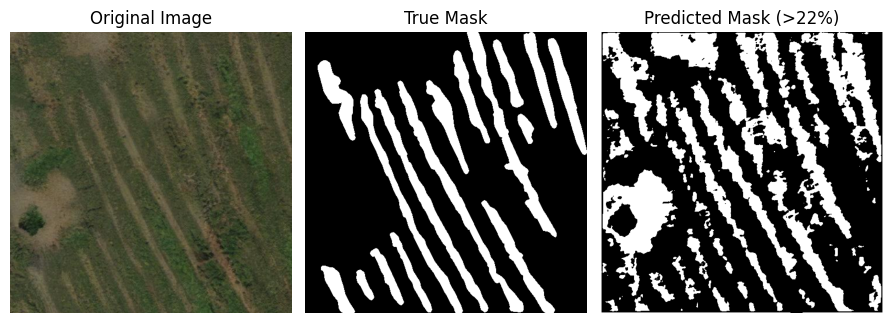

In [ ]:
new_image_path = "/content/drive/My Drive/Individual Project/test_image/test3.png"
true_mask_path = "/content/drive/My Drive/Individual Project/test_image/testmask3.png"
model = unet_model2
threshold = 0.22

visualise_prediction(new_image_path, true_mask_path, model, threshold)

## U-Net Model - Normalisation

In [ ]:
def unet_normalisation(input_size=(512, 512, 3)):
    inputs = Input(input_size)

    # Encoding path (contraction).
    # Block 1 - Two convolution layers and a max pooling layer.
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    # Block 2 - Two convolution layers and a max pooling layer.
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Block 3 - Two convolution layers and a max pooling layer.
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Block 4 - Two convolution layers and a max pooling layer.
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottleneck.
    # Block 5 - Two convolution layers.
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    # Decoding path (expansion).
    # Block 6 - Transpose layer, concatinating conv4, and two convolution layers.
    upsamp6 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5)
    merge6 = concatenate([conv4, upsamp6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)

    # Block 7 - Transpose layer, concatinating conv3, and two convolution layers.
    upsamp7 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    merge7 = concatenate([conv3, upsamp7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    # Block 8 - Transpose layer, concatinating conv2, and two convolution layers.
    upsamp8 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    merge8 = concatenate([conv2, upsamp8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)

    # Block 9 - Transpose layer, concatinating conv1, and two convolution layers.
    upsamp9 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    merge9 = concatenate([conv1, upsamp9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)

    # Output layer - Applying sigmoid activation.
    output = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=output)

    return model


### Instantiate and Compile U-Net model

In [ ]:
unet_model3 = unet_normalisation(input_size=(512, 512, 3))

optimiser = tf.keras.optimizers.Adam()
unet_model3.compile(optimizer=optimiser, loss='binary_focal_crossentropy', metrics=[iou])

#unet_model.summary()

### Training the U-Net model

In [ ]:
batch_size = 8
epochs = 10

model_history3 = unet_model3.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val, y_val))

unet_model2.save("updated_model.hdf5")

Epoch 1/10
10/10 [==============================] - 20s 2s/step - loss: 0.0607 - iou: 0.0918 - val_loss: 0.0930 - val_iou: 0.0706
Epoch 2/10
10/10 [==============================] - 21s 2s/step - loss: 0.0568 - iou: 0.0914 - val_loss: 0.0488 - val_iou: 0.0658
Epoch 3/10
10/10 [==============================] - 21s 2s/step - loss: 0.0535 - iou: 0.0925 - val_loss: 0.0665 - val_iou: 0.0735
Epoch 4/10
10/10 [==============================] - 22s 2s/step - loss: 0.0511 - iou: 0.0932 - val_loss: 0.0448 - val_iou: 0.0641
Epoch 5/10
10/10 [==============================] - 20s 2s/step - loss: 0.0491 - iou: 0.0920 - val_loss: 0.0628 - val_iou: 0.0739
Epoch 6/10
10/10 [==============================] - 21s 2s/step - loss: 0.0474 - iou: 0.0920 - val_loss: 0.0427 - val_iou: 0.0625
Epoch 7/10
10/10 [==============================] - 21s 2s/step - loss: 0.0462 - iou: 0.0912 - val_loss: 0.0420 - val_iou: 0.0639
Epoch 8/10
10/10 [==============================] - 21s 2s/step - loss: 0.0452 - iou: 0.09

### Evaluation Metrics

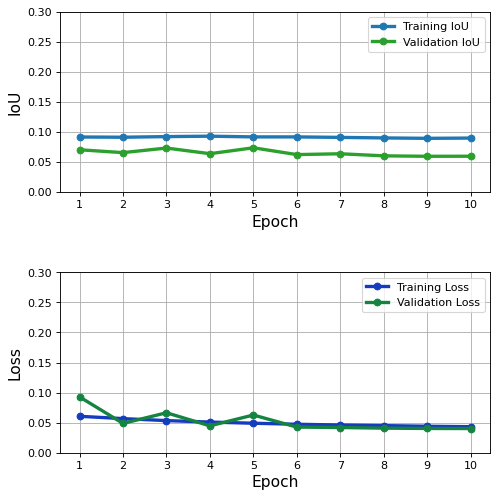

In [ ]:
evaluation_metrics(model_history3)

### Visualising predictions

1/1 [==============================] - 0s 25ms/step


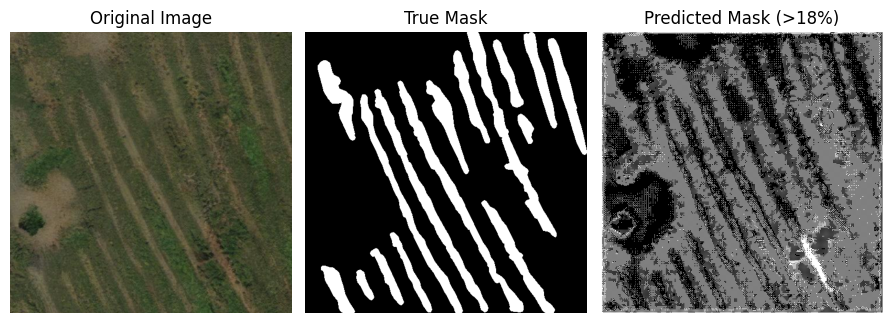

In [ ]:
new_image_path = "/content/drive/My Drive/Individual Project/test_image/test3.png"
true_mask_path = "/content/drive/My Drive/Individual Project/test_image/testmask3.png"
model = unet_model3
threshold = 0.185

visualise_prediction(new_image_path, true_mask_path, model, threshold)

## U-Net Model - Regularisation

In [ ]:
def unet_regularisation(input_size=(512, 512, 3)):
    inputs = Input(input_size)

    # Encoding path (contraction).
    # Block 1 - Two convolution layers and a max pooling layer.
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Dropout(0.1)(conv1)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    # Block 2 - Two convolution layers and a max pooling layer.
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Dropout(0.1)(conv2)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Block 3 - Two convolution layers and a max pooling layer.
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Dropout(0.1)(conv3)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Block 4 - Two convolution layers and a max pooling layer.
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Dropout(0.1)(conv4)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottleneck.
    # Block 5 - Two convolution layers.
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Dropout(0.1)(conv5)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # Decoding path (expansion).
    # Block 6 - Transpose layer, concatinating conv4, and two convolution layers.
    upsamp6 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5)
    merge6 = concatenate([conv4, upsamp6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Dropout(0.1)(conv6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    # Block 7 - Transpose layer, concatinating conv3, and two convolution layers.
    upsamp7 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    merge7 = concatenate([conv3, upsamp7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Dropout(0.1)(conv7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    # Block 8 - Transpose layer, concatinating conv2, and two convolution layers.
    upsamp8 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    merge8 = concatenate([conv2, upsamp8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Dropout(0.1)(conv8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    # Block 9 - Transpose layer, concatinating conv1, and two convolution layers.
    upsamp9 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    merge9 = concatenate([conv1, upsamp9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Dropout(0.1)(conv9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    # Output layer - Applying sigmoid activation.
    output = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=output)

    return model


### Instantiate and Compile U-Net model

In [ ]:
unet_model4 = unet_regularisation(input_size=(512, 512, 3))

optimiser = tf.keras.optimizers.Adam()
unet_model4.compile(optimizer=optimiser, loss='binary_focal_crossentropy', metrics=[iou])

#unet_model.summary()

### Training the U-Net model

In [ ]:
batch_size = 8
epochs = 10

model_history4 = unet_model4.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val, y_val))

unet_model4.save("updated_model2.hdf5")

Epoch 1/10
10/10 [==============================] - 23s 2s/step - loss: 0.0418 - iou: 0.0718 - val_loss: 0.0393 - val_iou: 0.0652
Epoch 2/10
10/10 [==============================] - 23s 2s/step - loss: 0.0418 - iou: 0.0720 - val_loss: 0.0392 - val_iou: 0.0658
Epoch 3/10
10/10 [==============================] - 23s 2s/step - loss: 0.0420 - iou: 0.0715 - val_loss: 0.0391 - val_iou: 0.0644
Epoch 4/10
10/10 [==============================] - 23s 2s/step - loss: 0.0419 - iou: 0.0715 - val_loss: 0.0394 - val_iou: 0.0622
Epoch 5/10
10/10 [==============================] - 23s 2s/step - loss: 0.0420 - iou: 0.0712 - val_loss: 0.0391 - val_iou: 0.0649
Epoch 6/10
10/10 [==============================] - 23s 2s/step - loss: 0.0417 - iou: 0.0726 - val_loss: 0.0390 - val_iou: 0.0670
Epoch 7/10
10/10 [==============================] - 23s 2s/step - loss: 0.0416 - iou: 0.0720 - val_loss: 0.0389 - val_iou: 0.0661
Epoch 8/10
10/10 [==============================] - 23s 2s/step - loss: 0.0417 - iou: 0.07

### Evaluation Metrics

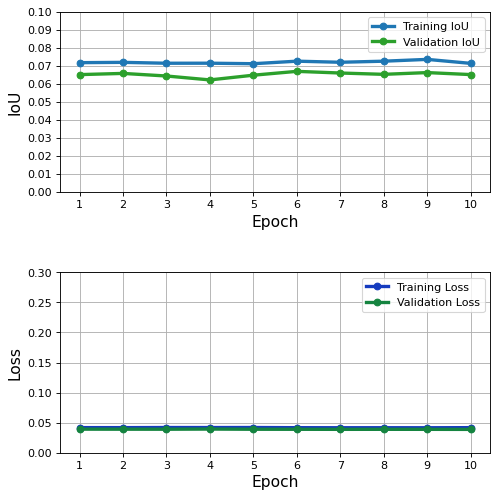

In [ ]:
evaluation_metrics(model_history4)

### Visualising predictions

1/1 [==============================] - 0s 33ms/step


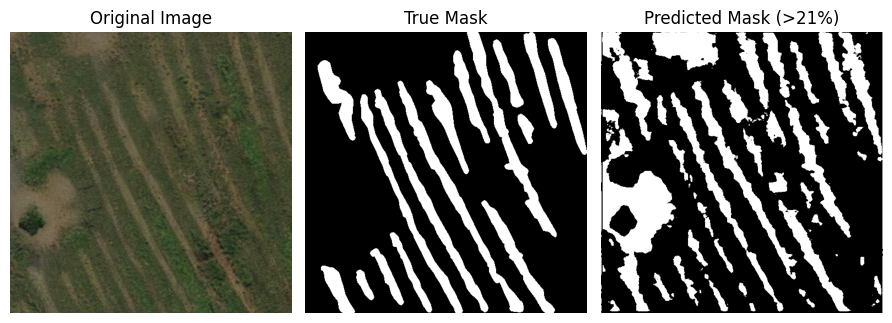

In [ ]:
new_image_path = "/content/drive/My Drive/Individual Project/test_image/test3.png"
true_mask_path = "/content/drive/My Drive/Individual Project/test_image/testmask3.png"
model = unet_model4
threshold = 0.21

visualise_prediction(new_image_path, true_mask_path, model, threshold)

## U-Net Model - Data Augmentation

### Augmented image paths

In [ ]:
aug_images_folder = "/content/drive/My Drive/Individual Project/aug_images"
aug_masks_folder = "/content/drive/My Drive/Individual Project/aug_masks"

### Load in images and masks

In [ ]:
aug_image_paths = sorted([os.path.join(aug_images_folder, file) for file in os.listdir(aug_images_folder)])
aug_mask_paths = sorted([os.path.join(aug_masks_folder, file) for file in os.listdir(aug_masks_folder)])

### Pre-process images

In [ ]:
aug_images = np.array([img_to_array(load_img(path, target_size=(512, 512))) for path in aug_image_paths])
aug_masks = np.array([img_to_array(load_img(path, target_size=(512, 512), color_mode="grayscale")) for path in aug_mask_paths])

### Normalise images

In [ ]:
aug_images = aug_images.astype(np.float32) / 255.0
aug_masks = aug_masks.astype(np.float32) / 255.0

### View Sample

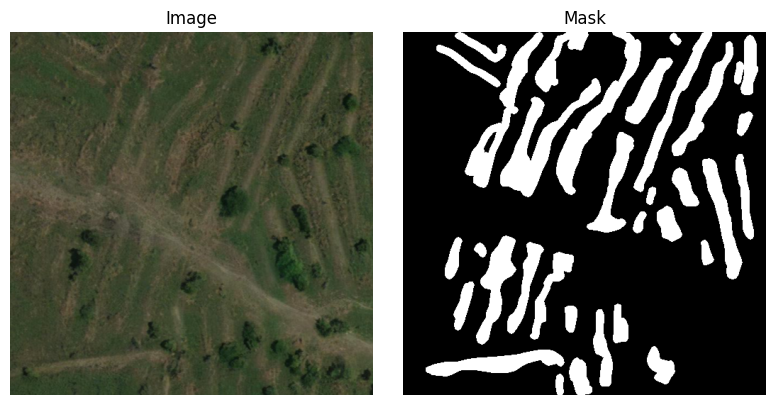

In [ ]:
sample_index = random.randint(0, len(aug_images))
display_sample_image_mask(aug_images, aug_masks, sample_index)

### Splitting the data into train and validation

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(aug_images, aug_masks, test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape)
print(X_val.shape)

(640, 512, 512, 3)
(160, 512, 512, 3)


### U-Net Model

In [6]:
def unet_regularisation(input_size=(512, 512, 3)):
    inputs = Input(input_size)

    # Encoding path (contraction).
    # Block 1 - Two convolution layers and a max pooling layer.
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Dropout(0.1)(conv1)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    # Block 2 - Two convolution layers and a max pooling layer.
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Dropout(0.1)(conv2)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Block 3 - Two convolution layers and a max pooling layer.
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Dropout(0.1)(conv3)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Block 4 - Two convolution layers and a max pooling layer.
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Dropout(0.1)(conv4)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottleneck.
    # Block 5 - Two convolution layers.
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Dropout(0.1)(conv5)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # Decoding path (expansion).
    # Block 6 - Transpose layer, concatinating conv4, and two convolution layers.
    upsamp6 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5)
    merge6 = concatenate([conv4, upsamp6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Dropout(0.1)(conv6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    # Block 7 - Transpose layer, concatinating conv3, and two convolution layers.
    upsamp7 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    merge7 = concatenate([conv3, upsamp7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Dropout(0.1)(conv7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    # Block 8 - Transpose layer, concatinating conv2, and two convolution layers.
    upsamp8 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    merge8 = concatenate([conv2, upsamp8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Dropout(0.1)(conv8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    # Block 9 - Transpose layer, concatinating conv1, and two convolution layers.
    upsamp9 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    merge9 = concatenate([conv1, upsamp9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Dropout(0.1)(conv9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    # Output layer - Applying sigmoid activation.
    output = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=output)

    return model


### Instantiate and Compile U-Net model

In [8]:
unet_model5 = unet_regularisation(input_size=(512, 512, 3))

def iou(y_true, y_pred):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    intersection = K.sum(y_true_flatten * y_pred_flatten)
    return (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)

early_stopping = EarlyStopping(monitor='val_iou', patience=5, restore_best_weights=True)

optimiser = tf.keras.optimizers.Adam()
unet_model5.compile(optimizer=optimiser, loss='binary_focal_crossentropy', metrics=[iou])

unet_model5.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 512, 512, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_9 (Dropout)            (None, 512, 512, 64  0           ['conv2d_19[0][0]']              
                                )                                                           

### Training the U-Net model

In [ ]:
batch_size = 8
epochs = 10

model_history5 = unet_model5.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

unet_model5.save("optimised_model_augmentation.hdf5")

Epoch 1/10
80/80 [==============================] - 232s 2s/step - loss: 0.0468 - iou: 0.0626 - val_loss: 0.0404 - val_iou: 0.0706
Epoch 2/10
80/80 [==============================] - 179s 2s/step - loss: 0.0415 - iou: 0.0710 - val_loss: 0.0397 - val_iou: 0.0702
Epoch 3/10
80/80 [==============================] - 179s 2s/step - loss: 0.0415 - iou: 0.0709 - val_loss: 0.0399 - val_iou: 0.0729
Epoch 4/10
80/80 [==============================] - 178s 2s/step - loss: 0.0412 - iou: 0.0719 - val_loss: 0.0397 - val_iou: 0.0723
Epoch 5/10
80/80 [==============================] - 178s 2s/step - loss: 0.0411 - iou: 0.0729 - val_loss: 0.0396 - val_iou: 0.0710
Epoch 6/10
80/80 [==============================] - 178s 2s/step - loss: 0.0411 - iou: 0.0725 - val_loss: 0.0395 - val_iou: 0.0721
Epoch 7/10
80/80 [==============================] - 179s 2s/step - loss: 0.0413 - iou: 0.0724 - val_loss: 0.0395 - val_iou: 0.0715


In [ ]:
unet_model5.save("optimised_model_augmentation.hdf5")

### Evaluation Metrics

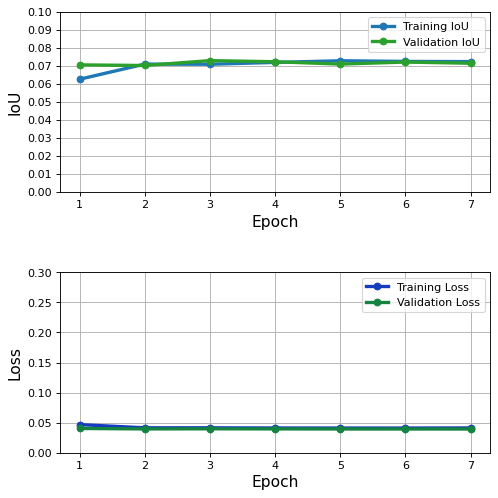

In [ ]:
evaluation_metrics(model_history5)

### Visualising predictions

1/1 [==============================] - 0s 23ms/step


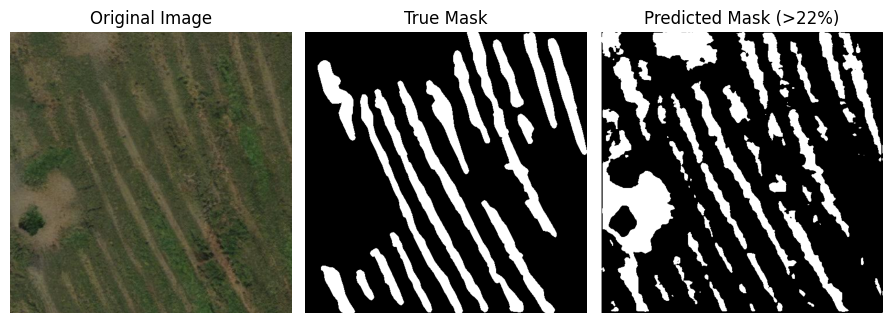

In [ ]:
new_image_path = "/content/drive/My Drive/Individual Project/test_image/test3.png"
true_mask_path = "/content/drive/My Drive/Individual Project/test_image/testmask3.png"
model = unet_model5
threshold = 0.22

visualise_prediction(new_image_path, true_mask_path, model, threshold)

# Model testing

### Testing new image

1/1 [==============================] - 0s 21ms/step


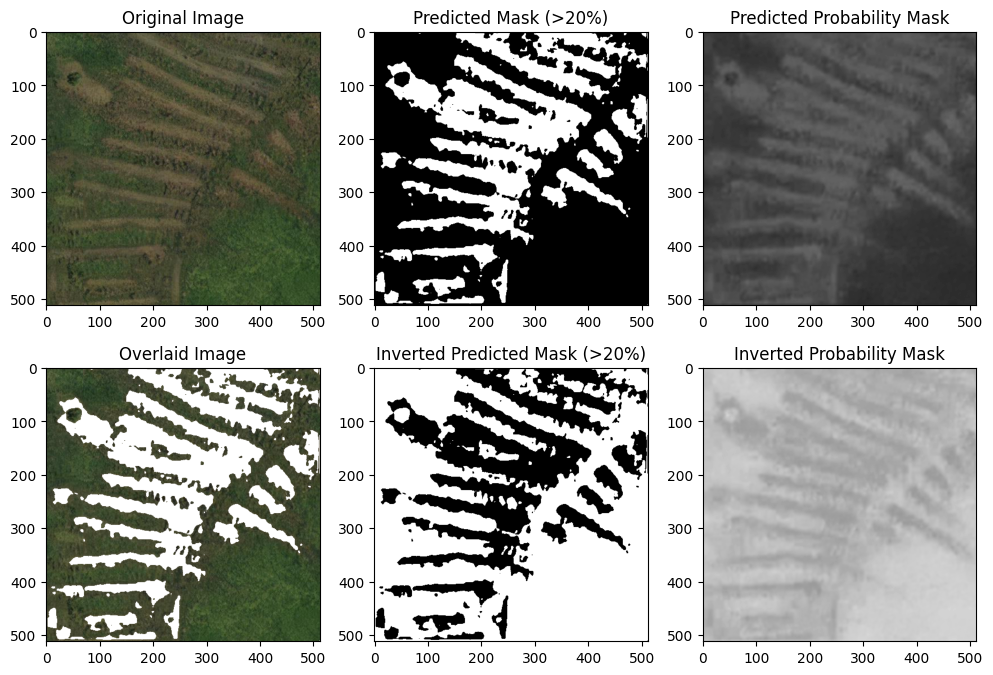

In [ ]:
# Load in the new image.
new_image = plt.imread("/content/drive/My Drive/Individual Project/test_image/test2.png")

# Remove the alpha channel.
if new_image.shape[2] == 4:
    new_image = new_image[..., :3]

# Resize image, and add the batch dimension to make it compatible with CNN.
new_image_resized = resize(new_image, (512, 512))
new_image_batch = np.expand_dims(new_image_resized, axis=0)

# Make a prediction.
model = unet_model5
prediction = model.predict(new_image_batch)

# Create a binary mask. Each pixel value will be 1 or 0 dependent the confidence threshold.
threshold = 0.21
predicted_mask = (prediction > threshold).astype(np.uint8)[0, ..., 0]
inverted_mask = 1 - predicted_mask

# Normalise the prediction probabilities.
prob_multiplier = 1.5
predicted_probabilities = prediction[0, ..., 0] * prob_multiplier
inverted_probabilities = 1 - predicted_probabilities

# # True mask
# true_mask = plt.imread("/content/drive/My Drive/Individual Project/test_image/cropped-screenshot (15) mask.png")

# if true_mask.shape[2] == 4:
#     new_mask_image = true_mask[..., :3]

# true_mask_gray = rgb2gray(new_mask_image)
# true_mask_normalised = (true_mask_gray.astype(np.float32) / 255.0)

# Overlaying the white predictions onto the original image.
overlayed_image = new_image_resized.copy()
overlayed_image[predicted_mask > 0] = 255
overlayed_image = np.clip(overlayed_image, 0, 1)

# Convert the new image into 0-255 int values so it can be visualised.
original_image = (new_image_resized * 255).astype(np.uint8)

# Visualise image and outputs.
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Original image.
axes[0, 0].imshow(original_image)
axes[0, 0].set_title("Original Image")

# Predicted mask.
axes[0, 1].imshow(predicted_mask, cmap='gray')
axes[0, 1].set_title("Predicted Mask (>20%)")

# Predicted probability mask.
axes[0, 2].imshow(predicted_probabilities, cmap='gray', vmin=0, vmax=1)
axes[0, 2].set_title("Predicted Probability Mask")

# Predicted mask overlaid image.
axes[1, 0].imshow(overlayed_image)
axes[1, 0].set_title("Overlaid Image")

# axes[1, 1].imshow(true_mask_gray, cmap="gray")
# axes[1, 1].set_title("True Mask")

# Inverted predicted mask.
axes[1, 1].imshow(inverted_mask, cmap="gray", vmin=0, vmax=1)
axes[1, 1].set_title("Inverted Predicted Mask (>20%)")

# Inverted probability mask.
axes[1, 2].imshow(inverted_probabilities, cmap='gray', vmin=0, vmax=1)
axes[1, 2].set_title("Inverted Probability Mask")

plt.show()


In [ ]:
print(prediction)

[[[[0.27816045]
   [0.22070374]
   [0.21153791]
   ...
   [0.24698618]
   [0.24991569]
   [0.30808857]]

  [[0.23094425]
   [0.16873306]
   [0.15717313]
   ...
   [0.20353085]
   [0.19309649]
   [0.23571809]]

  [[0.21996237]
   [0.15266532]
   [0.14214505]
   ...
   [0.19294477]
   [0.1802951 ]
   [0.21794608]]

  ...

  [[0.23230094]
   [0.16316935]
   [0.14830367]
   ...
   [0.10594331]
   [0.10339259]
   [0.14973515]]

  [[0.22065006]
   [0.14916854]
   [0.13630761]
   ...
   [0.10114061]
   [0.09862724]
   [0.15552674]]

  [[0.25752273]
   [0.17726214]
   [0.1612852 ]
   ...
   [0.13352257]
   [0.1415678 ]
   [0.21451484]]]]


In [ ]:
# Save images as PNG files
# plt.imsave('original_image.png', original_image)
# plt.imsave('predicted_mask.png', predicted_mask, cmap='gray')
# plt.imsave('predicted_probabilities.png', predicted_probabilities, cmap='gray', vmin=0, vmax=1)
# plt.imsave('overlayed_image.png', overlayed_image)
# plt.imsave('inverted_mask.png', inverted_mask, cmap="gray", vmin=0, vmax=1)
# plt.imsave('inverted_probabilities.png', inverted_probabilities, cmap='gray', vmin=0, vmax=1)

# files.download('original_image.png')
# files.download('predicted_mask.png')
# files.download('predicted_probabilities.png')
# files.download('overlayed_image.png')
# files.download('inverted_mask.png')
# files.download('inverted_probabilities.png')


